# Correlation analysis between the Bitcoin currency and Twitter

This project consists of a correlation analysis between the Bitcoin currency and tweets. In order to define the positiveness of a tweet (if the course of the bitcoin will go up or down), we realise a sentiment analysis of each tweet using the VADER algorithm. Finally we try to find a correlation between the two and we will make some machine learning to make predictions.

This notebook was written using Python 3.6.

## Import the Python dependencies
For this project we need Pandas to manage all of our datasets.

You will need to run the following commands with pip to install the dependencies:

```
pip install VaderSentiment
pip install pandas
pip install tqdm
...
```

You can also run `pip install .` from the project's root folder to install all the requirements from the `requirements.txt` file.

In [91]:
import json
import pandas as pd
import io
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook, tqdm
import glob
from datetime import datetime, timedelta

In [92]:

crypto=pd.read_csv("BTC.csv")
tweets=pd.read_csv("btc-sentiment.csv")

## Load the datasets

We read the data generated from two other notebooks, TwitterExtraction and CryptoCurrencyExtraction. The extraction process is detailed in these notebooks so please refer to them for any information needed. Here we simply gather all the extracted data to generate two datasets :

- The twitter dataset : contains historical tweets related to the targeted crypto currency with a sentiment score.
- The crypo dataset : contains historical data of the crypto currency we target with the change in USD.

### Twitter dataset

The data is split into multiple files. Here it is gathered into a single dataframe.

### Crypto dataset

In [93]:

crypto["time"]=crypto["unix"]
crypto=crypto[["close","high","low","open","time"]]
crypto

,close,high,low,open,time
0,3693.30,3693.30,3689.26,3689.26,1546300740
1,3691.35,3691.35,3689.26,3689.26,1546300680
2,3689.26,3689.26,3688.83,3688.83,1546300620
3,3686.92,3689.65,3686.92,3687.87,1546300560
4,3688.85,3688.85,3685.00,3688.28,1546300500
...,...,...,...,...,...
525594,13737.93,13826.10,13734.45,13826.10,1514765100
525595,13803.20,13826.75,13803.20,13823.19,1514765040
525596,13823.19,13874.92,13823.19,13847.51,1514764980
525597,13847.51,13890.35,13846.64,13846.64,1514764920


### Tweets Dataset

In [94]:
tweets['text']=tweets["Tweet"]
tweets["sentiment"]=tweets["New_Sentiment_Score"]
tweets["CreatedAt"]=tweets["Date"]
tweets

,id,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State,BERT Labels,text,sentiment,CreatedAt
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0,1,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",0.000000,Fri Mar 23 00:40:32 +0000 2018
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,0.000000,0.0,0,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,0.000000,Fri Mar 23 00:40:34 +0000 2018
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.136364,1.0,0,RT @tippereconomy: Another use case for #block...,0.136364,Fri Mar 23 00:40:35 +0000 2018
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.400000,1.0,0,free coins https://t.co/DiuoePJdap,0.400000,Fri Mar 23 00:40:36 +0000 2018
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,0.468182,1.0,0,RT @payvxofficial: WE are happy to announce th...,0.468182,Fri Mar 23 00:40:36 +0000 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50847,50854,Fri Mar 23 08:55:16 +0000 2018,RT @fixy_app: Fixy Network brings popular cryp...,quoting_lives,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.600000,1.0,0,RT @fixy_app: Fixy Network brings popular cryp...,0.600000,Fri Mar 23 08:55:16 +0000 2018
50848,50855,Fri Mar 23 08:55:17 +0000 2018,RT @bethereumteam: After a successful launch o...,VariPewitt,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.375000,1.0,2,RT @bethereumteam: After a successful launch o...,0.375000,Fri Mar 23 08:55:17 +0000 2018
50849,50856,Fri Mar 23 08:55:18 +0000 2018,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",urbancoinerz,"[u'GYMRewards', u'ICO', u'cryptocurrency', u'm...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0,1,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",0.000000,Fri Mar 23 08:55:18 +0000 2018
50850,50857,Fri Mar 23 08:55:19 +0000 2018,I added a video to a @YouTube playlist https:/...,MRDanishShahab,[],"<a href=""http://www.google.com/"" rel=""nofollow...",['positive'],1.0,0.400000,1.0,0,I added a video to a @YouTube playlist https:/...,0.400000,Fri Mar 23 08:55:19 +0000 2018


In [95]:
tweets["score"]=tweets["sent_score"]

In [96]:
tweets

,id,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State,BERT Labels,text,sentiment,CreatedAt,score
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0,1,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",0.000000,Fri Mar 23 00:40:32 +0000 2018,0.0
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,0.000000,0.0,0,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,0.000000,Fri Mar 23 00:40:34 +0000 2018,0.0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.136364,1.0,0,RT @tippereconomy: Another use case for #block...,0.136364,Fri Mar 23 00:40:35 +0000 2018,1.0
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.400000,1.0,0,free coins https://t.co/DiuoePJdap,0.400000,Fri Mar 23 00:40:36 +0000 2018,1.0
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,0.468182,1.0,0,RT @payvxofficial: WE are happy to announce th...,0.468182,Fri Mar 23 00:40:36 +0000 2018,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50847,50854,Fri Mar 23 08:55:16 +0000 2018,RT @fixy_app: Fixy Network brings popular cryp...,quoting_lives,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.600000,1.0,0,RT @fixy_app: Fixy Network brings popular cryp...,0.600000,Fri Mar 23 08:55:16 +0000 2018,1.0
50848,50855,Fri Mar 23 08:55:17 +0000 2018,RT @bethereumteam: After a successful launch o...,VariPewitt,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.375000,1.0,2,RT @bethereumteam: After a successful launch o...,0.375000,Fri Mar 23 08:55:17 +0000 2018,1.0
50849,50856,Fri Mar 23 08:55:18 +0000 2018,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",urbancoinerz,"[u'GYMRewards', u'ICO', u'cryptocurrency', u'm...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0,1,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",0.000000,Fri Mar 23 08:55:18 +0000 2018,0.0
50850,50857,Fri Mar 23 08:55:19 +0000 2018,I added a video to a @YouTube playlist https:/...,MRDanishShahab,[],"<a href=""http://www.google.com/"" rel=""nofollow...",['positive'],1.0,0.400000,1.0,0,I added a video to a @YouTube playlist https:/...,0.400000,Fri Mar 23 08:55:19 +0000 2018,1.0


In [97]:
crypto_usd = crypto
crypto_usd = crypto_usd.sort_values(by=['time'])

In [98]:
# Drop duplicates
print('bitcoin shape before droping duplicates', crypto_usd.shape)
duplicates_removed = crypto_usd.shape[0]
crypto_usd = crypto_usd.drop_duplicates(subset=['time'])
print('bitcoin shape after droping duplicates', crypto_usd.shape)
duplicates_removed -= crypto_usd.shape[0]
print('duplicates removed', duplicates_removed)
crypto_usd.head(2)

bitcoin shape before droping duplicates (525599, 5)
bitcoin shape after droping duplicates (525599, 5)
duplicates removed 0


,close,high,low,open,time
525598,13890.43,13890.43,13841.01,13841.01,1514764860
525597,13847.51,13890.35,13846.64,13846.64,1514764920


## Group by and sum by timeframe

In [99]:
import pandas as pd

# For tweets DataFrame
tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'], utc=True)
tweets = tweets.set_index('CreatedAt')  # Set index to the timestamp column
tweets_grouped = tweets.resample('1h')['score'].sum()

# For crypto_usd DataFrame
crypto_usd['time'] = pd.to_datetime(crypto_usd['time'], unit='s')
crypto_usd = crypto_usd.set_index('time')  # Set index to the timestamp column
crypto_usd_grouped = crypto_usd.resample('1h')['close'].mean()


/tmp/ipykernel_32362/3769857001.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets['CreatedAt'] = pd.to_datetime(tweets['CreatedAt'], utc=True)


## Correlation analysis
Here we make the correlation analysis between BTC/USD currency derivative and the tweets scores derivative.

We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series.
https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [100]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

### Crop the time series to match the time frames

In [101]:
import pytz

# Convert index to timezone-naive timestamps
tweets_grouped.index = tweets_grouped.index.tz_localize(None)
crypto_usd_grouped.index = crypto_usd_grouped.index.tz_localize(None)

# Get the beginning and end timestamps for comparison
beginning = max(tweets_grouped.index.min(), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max(), crypto_usd_grouped.index.max())

# Slice the DataFrames based on the beginning and end timestamps
tweets_grouped = tweets_grouped[(tweets_grouped.index >= beginning) & (tweets_grouped.index <= end)]
crypto_usd_grouped = crypto_usd_grouped[(crypto_usd_grouped.index >= beginning) & (crypto_usd_grouped.index <= end)]


In [102]:
crypto_usd_grouped['2019-07-25 22:00:00'] = 9886.7824 

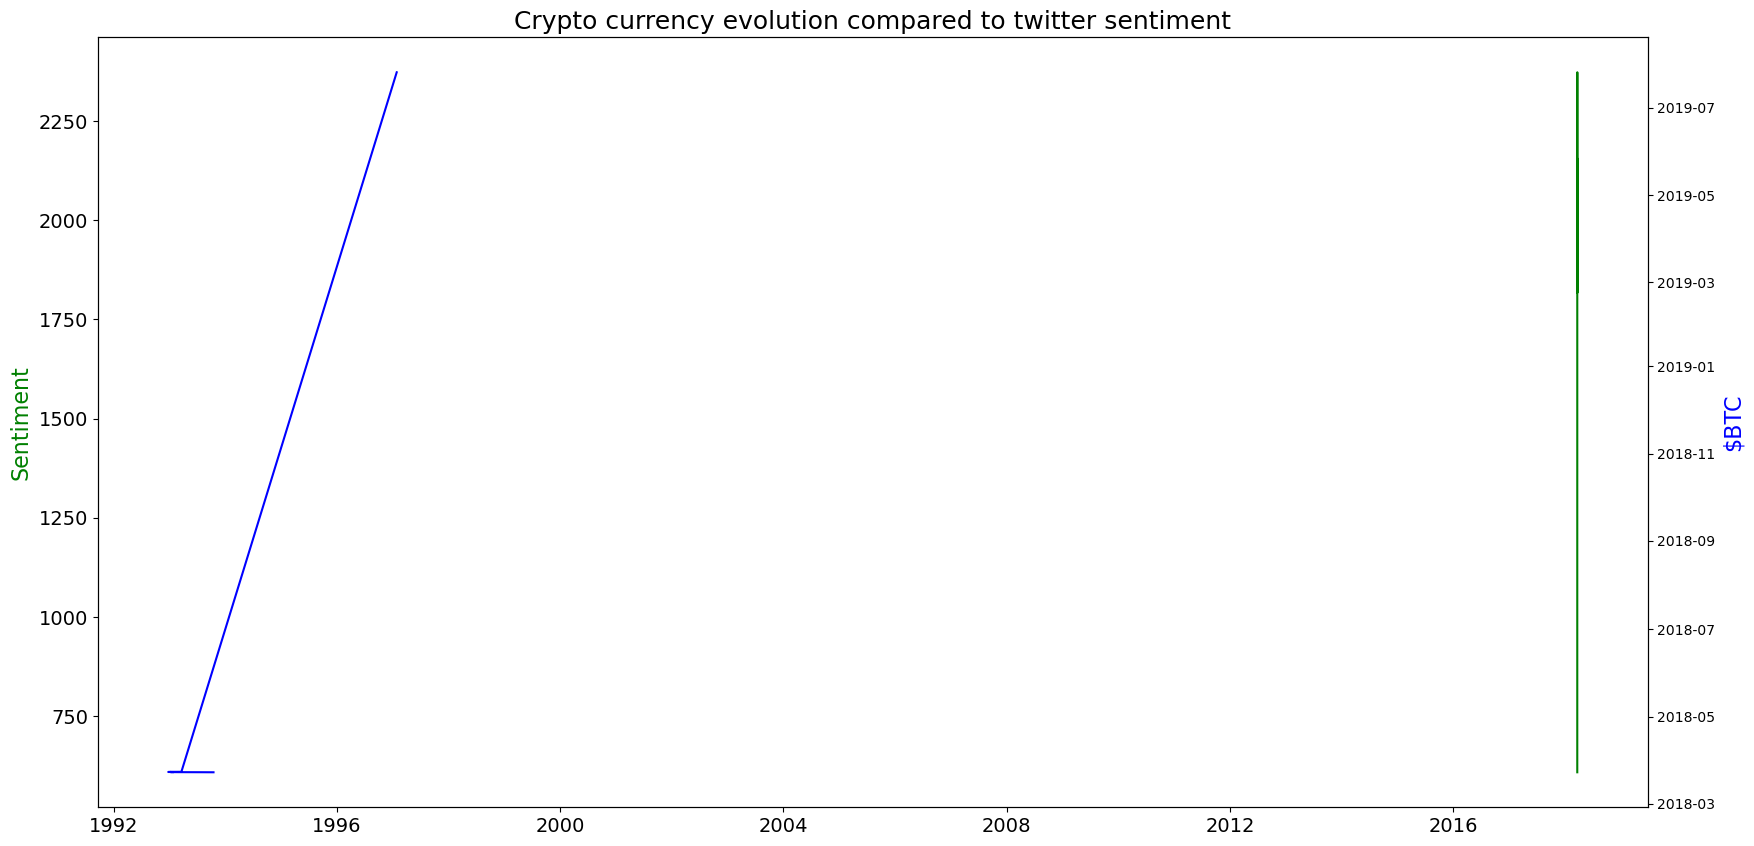

In [103]:
import numpy as np 
import matplotlib.pyplot as plt

# Convert index and data to numpy arrays
tweets_index_np = np.array(tweets_grouped.index)
tweets_data_np = np.array(tweets_grouped)
crypto_usd_grouped_np=np.array(crypto_usd_grouped)
crypto_usd_data_np=np.array(crypto_usd_grouped.index)

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()

# Plot using numpy arrays
ax1.plot_date(tweets_index_np, tweets_data_np, 'g-')
ax2.plot_date(crypto_usd_grouped_np, crypto_usd_data_np, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("$BTC", color='b', fontsize=16)

plt.show()


/home/hamza/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/hamza/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/hamza/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


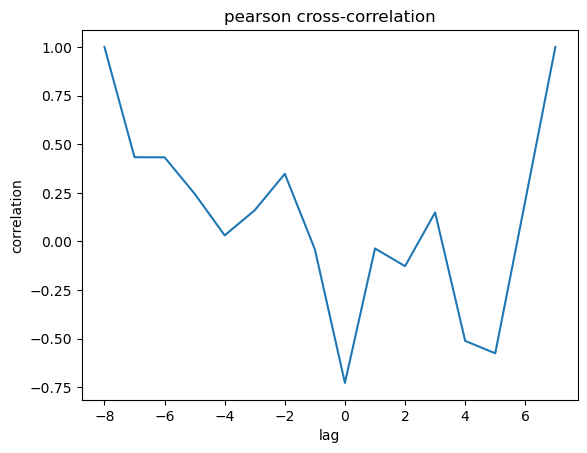

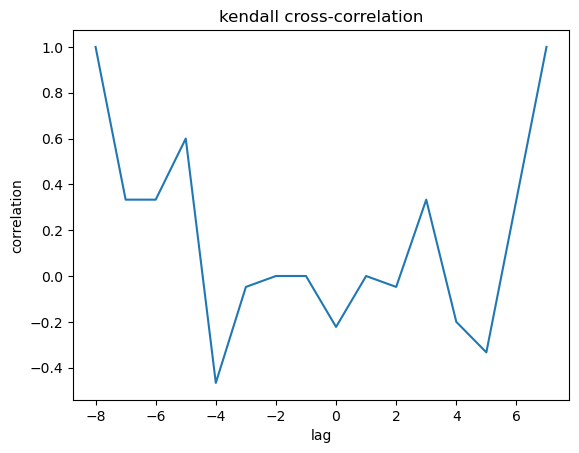

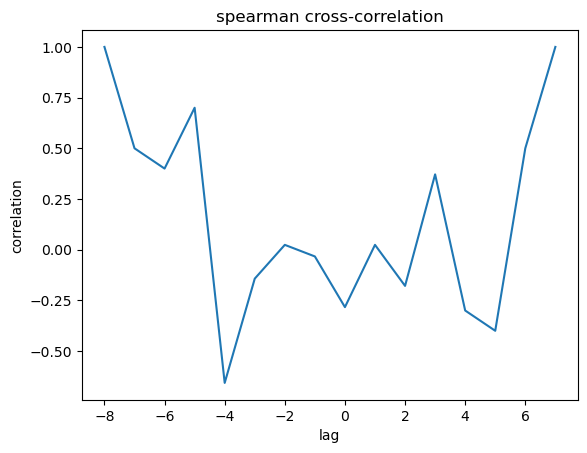

In [104]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize 
First we need to normalize the data.

AttributeError: 'str' object has no attribute 'items'

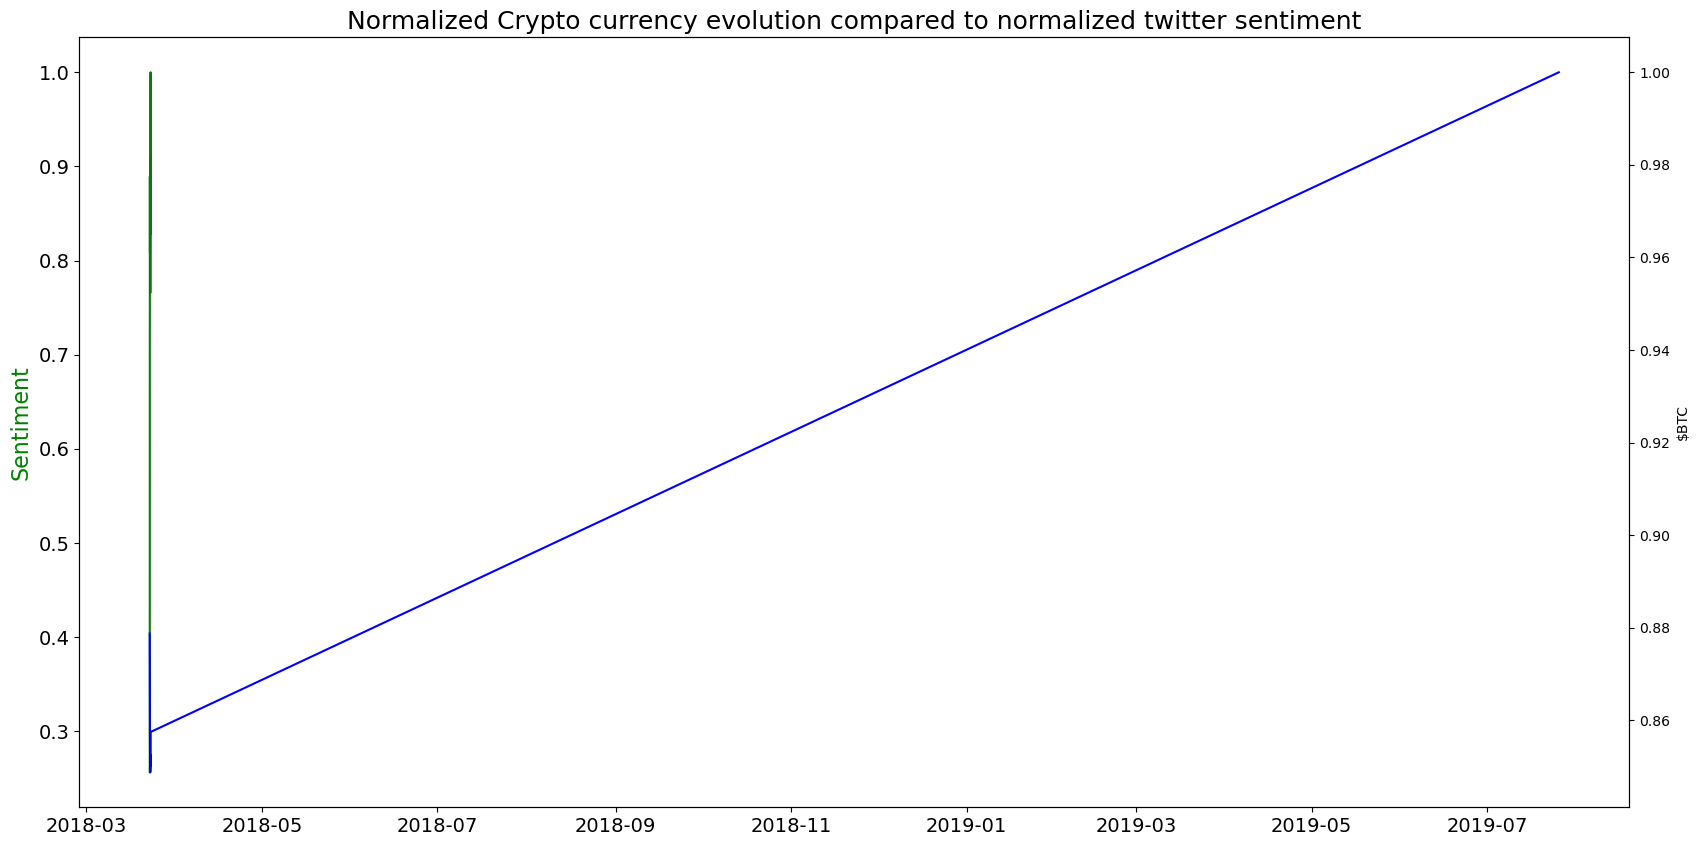

In [106]:
# Normalize time series data
tweets_grouped = tweets_grouped / max(tweets_grouped.max(), abs(tweets_grouped.min()))
crypto_usd_grouped = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(np.array(tweets_grouped.index), np.array(tweets_grouped), 'g-')
ax2.plot_date(np.array(crypto_usd_grouped.index), np.array(crypto_usd_grouped), 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("$BTC", color='b', fontsize=16)
plt.show()

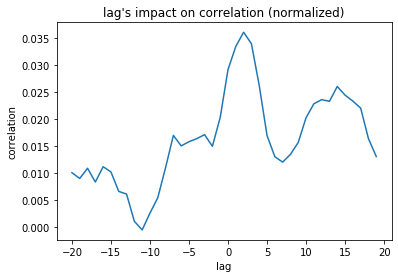

In [ ]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Calculate derivative

The derivative is calculated to define an increase or a decrease of the crypto currency.

The score is as well derivated to observe the increase or decrease of the score.

Computing the derivative could help to find a correlation.

In [ ]:
# Derivative
tweets_grouped = pd.Series(np.gradient(tweets_grouped.values), tweets_grouped.index, name='slope')
crypto_usd_grouped = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

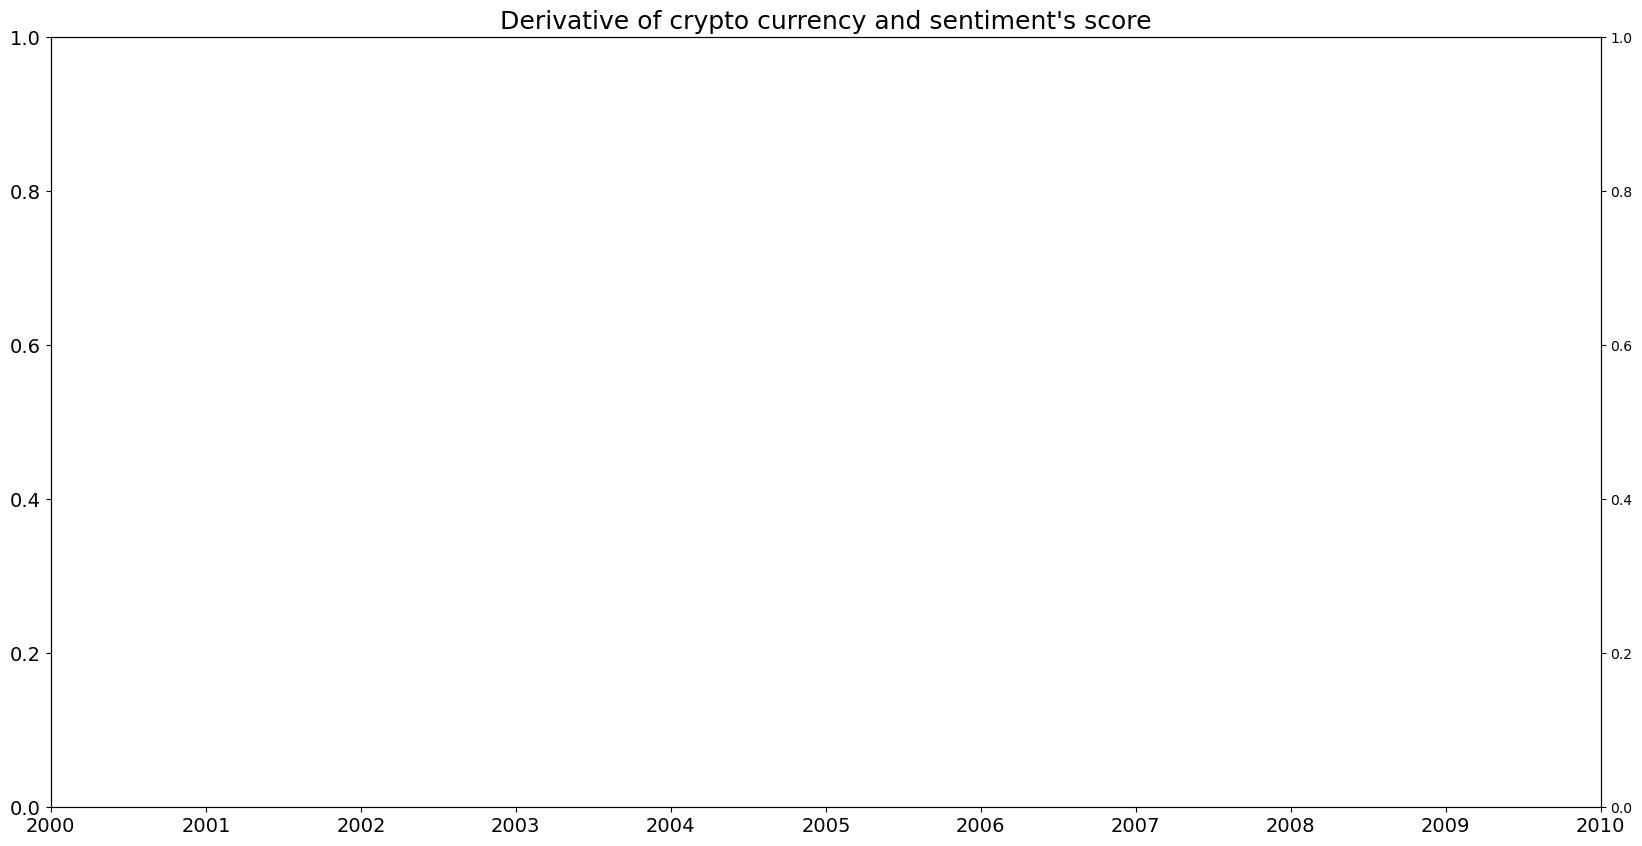

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel(f"{CURRENCY_SYMBOL}'s derivative'", color='b', fontsize=16)
plt.show()

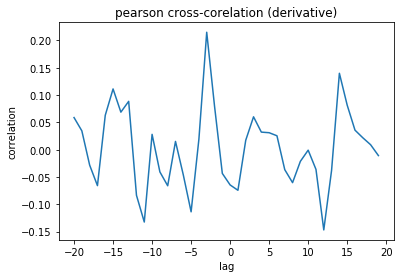

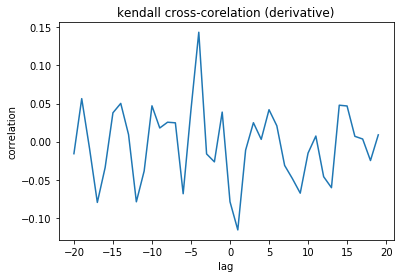

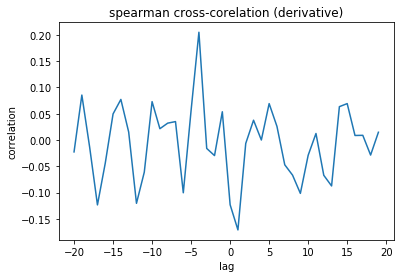

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Realtime correlation viewer
We can stream the new tweets about the crypto using the TwythonStreamer module. 

Using the CryptoCompare API we can also retrieve the crypto currency in realtime using sockets.

Finally we can plot it with Plotly.

In [ ]:
# update historical data until today
file = open("current_crypto.txt", "w") 
file.write(CURRENCY_SYMBOL)
file.close()
%run 03_CryptoCurrencyExtraction.ipynb

BTC
1563052380
2019-07-13 21:03:00
2019-07-13 21:13:00
(11, 5)
range= 2019-07-12 11:53:00 2019-07-13 21:13:00
range= 2019-07-11 02:33:00 2019-07-12 11:53:00
range= 2019-07-09 17:13:00 2019-07-11 02:33:00
range= 2019-07-08 07:53:00 2019-07-09 17:13:00
range= 2019-07-06 23:32:00 2019-07-08 07:53:00
81
df_to_fulfill (9919, 5)
df_remaining (27, 5)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


done


data/crypto/BTC/2019-07-13 20-47-00~2019-07-13 21-13-00.csv
data/crypto/BTC/2019-07-06 22-08-00~2019-07-13 20-46-00.csv
df shape (500, 5)
from 2019-07-13 12-54-00 to 2019-07-13 21-13-00


In [ ]:
def get_most_recent_data_from_csv(folder, n_rows):
    '''
    @ folder : relative path where the data is contained
    @ n_rows : the number of rows to retrieve up to the most recent ones
    
    Return a dataframe containing n_rows of the most recent data retrieved
    '''
    files =  glob.glob(f"{folder}/*.csv")
    files = sorted(files)
    df = pd.DataFrame()
    for file in reversed(files):
        print(file)
        df = df.append(pd.read_csv(file))
        if df.shape[0] > n_rows:
            break
    return df.sort_values(by=['time']).tail(n_rows)

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime, timedelta
from time import sleep
import plotly.tools as tls  

# Get stream id from stream id list
stream_id_crypto, stream_id_tweets = tls.get_credentials_file()['stream_ids'][:2]

# Make instance of stream id object 
stream_tweets = go.Stream(
    token=stream_id_tweets,  # link stream id to 'token' key
    maxpoints=1500      # keep a max of 80 pts on screen
)

stream_crypto = go.Stream(
    token=stream_id_crypto,  # link stream id to 'token' key
    maxpoints=200      # keep a max of 80 pts on screen
)

# Initialize trace of streaming plot by embedding the unique stream_id
trace_tweets = go.Scatter(x=[], y=[], mode='lines', name='Sentiments', stream=stream_tweets)

CRYPTO_FOLDER = f"data/crypto/{CURRENCY_SYMBOL}"
crypto_usd_updated = get_most_recent_data_from_csv(CRYPTO_FOLDER, 5)
# Drop duplicates
crypto_usd_updated = crypto_usd_updated.drop_duplicates(subset=['time'])
trace_crypto = go.Scatter(x=crypto_usd_updated['time'].tail(200).apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')),
                          y=crypto_usd_updated['close'].tail(200), yaxis='y2', stream=stream_crypto, name = CURRENCY_SYMBOL)

#data = [trace_crypto, trace_tweets]
data = [trace_crypto, trace_tweets]

# Add title to layout object
layout = go.Layout(
    title=f"{CURRENCY_SYMBOL} currency and tweets sentiments",
    legend=dict(orientation="h"),
    yaxis=dict(
        title='Sentiment score',
        titlefont=dict(
            color='rgb(255, 119, 0)'
        ),
        tickfont=dict(
            color='rgb(255, 119, 0)'
        )
    ),
    yaxis2=dict(
        title='{CURRENCY_SYMBOL} Price ($ USD)',
        titlefont=dict(
            color='rgb(33, 118, 180)'
        ),
        tickfont=dict(
            color='rgb(33, 118, 180)'
        ),
        overlaying='y',
        side='right'
    )
)

# Make a figure object
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename=f"real_time_{CURRENCY_SYMBOL}_tweets", fileopt="overwrite")

ValueError: not enough values to unpack (expected 2, got 0)

### Before continuing, run the crypto streamer first

Open your terminal and execute this command at the same level as this notebook. You first need to have [npm with node](https://www.npmjs.com/get-npm) installed on your machine.

- `cd streamer && npm install && node stream_crypto.js`

Altenrativaley, you can run this line inside a jupyter notebook but it makes the cell block 

- `! cd streamer && npm install && node stream_crypto.js`

### Once the crypto streamer is run you can run the following cell to stream the tweets

In [ ]:
from twython import TwythonStreamer
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# We will provide the stream link object the same token that's associated with the trace we wish to stream to
#s_crypto = py.Stream(stream_id_crypto)
s_tweets = py.Stream(stream_id_tweets)

# We then open a connection
#s_crypto.open()
s_tweets.open()

# Vader sentiment analyser
analyzer = SentimentIntensityAnalyzer()

class MyStreamer(TwythonStreamer):
    def on_success(self, data):
        if 'text' in data:
            # x value: date
            date_str = data['created_at']
            time_struct = time.strptime(date_str, "%a %b %d %H:%M:%S +0000 %Y")#Tue Apr 26 08:57:55 +0000 2011
            date = datetime.fromtimestamp(time.mktime(time_struct))
            date = date + timedelta(hours=4) # hack to sync tweet's date to current time
            
            # y value: sentiment of the tweet
            text = data['text']
            vs = analyzer.polarity_scores(text)
            score = vs["compound"] * (data["user"]["followers_count"]+1) * (data["favorite_count"]+1)
            #print(date, score)
            s_tweets.write(dict(type='scatter',
                 x=date,y=score))

    def on_error(self, status_code, data):
        print(status_code, data)

        # Want to stop trying to get data because of the error?
        # Uncomment the next line!
        # self.disconnect()
        
APP_KEY = 'mPQKoRwd2Pb9qpQyQmyG5s8KR'
APP_SECRET = 'HLvIhusvfzDLKaRXY8CnZGP143kp3E3f2KqQBIEMfVL5mOxZjq'
OAUTH_TOKEN = "3459248236-0XPtHldG3ou6BfpTwaKWnOL2ywFk2niQekLwE7K"
OAUTH_TOKEN_SECRET = "08Vy2wuOkp7AmuC3rbjCHFJ94MLG2sWqdvGQtoiXmkVKr"

stream = MyStreamer(APP_KEY, APP_SECRET,
                    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
stream.statuses.filter(track=['#bitcoin', '#BTC'], lang='en')

KeyboardInterrupt: 

### To stop the real time data retrieving, stop the kernel in this notebook and press Ctrl+C in your terminal

In [ ]:
# Close the stream when done plotting
s_tweets.close() 